In [14]:
import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from genjax import grasp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import numpy as np

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

In [15]:
grasp

<module 'genjax.grasp' from '/home/femtomc/Research/genjax/src/genjax/grasp.py'>

## Model

In [16]:
@genjax.gen
def model():
    x = grasp.normal_reparam(0.0, 10.0) @ "x"
    y = grasp.normal_reparam(0.0, 10.0) @ "y"
    rs = x**2 + y**2
    z = grasp.normal_reparam(rs, 0.1 + (rs / 100.0)) @ "z"

In [17]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 100000)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, ())
chm = tr.strip()

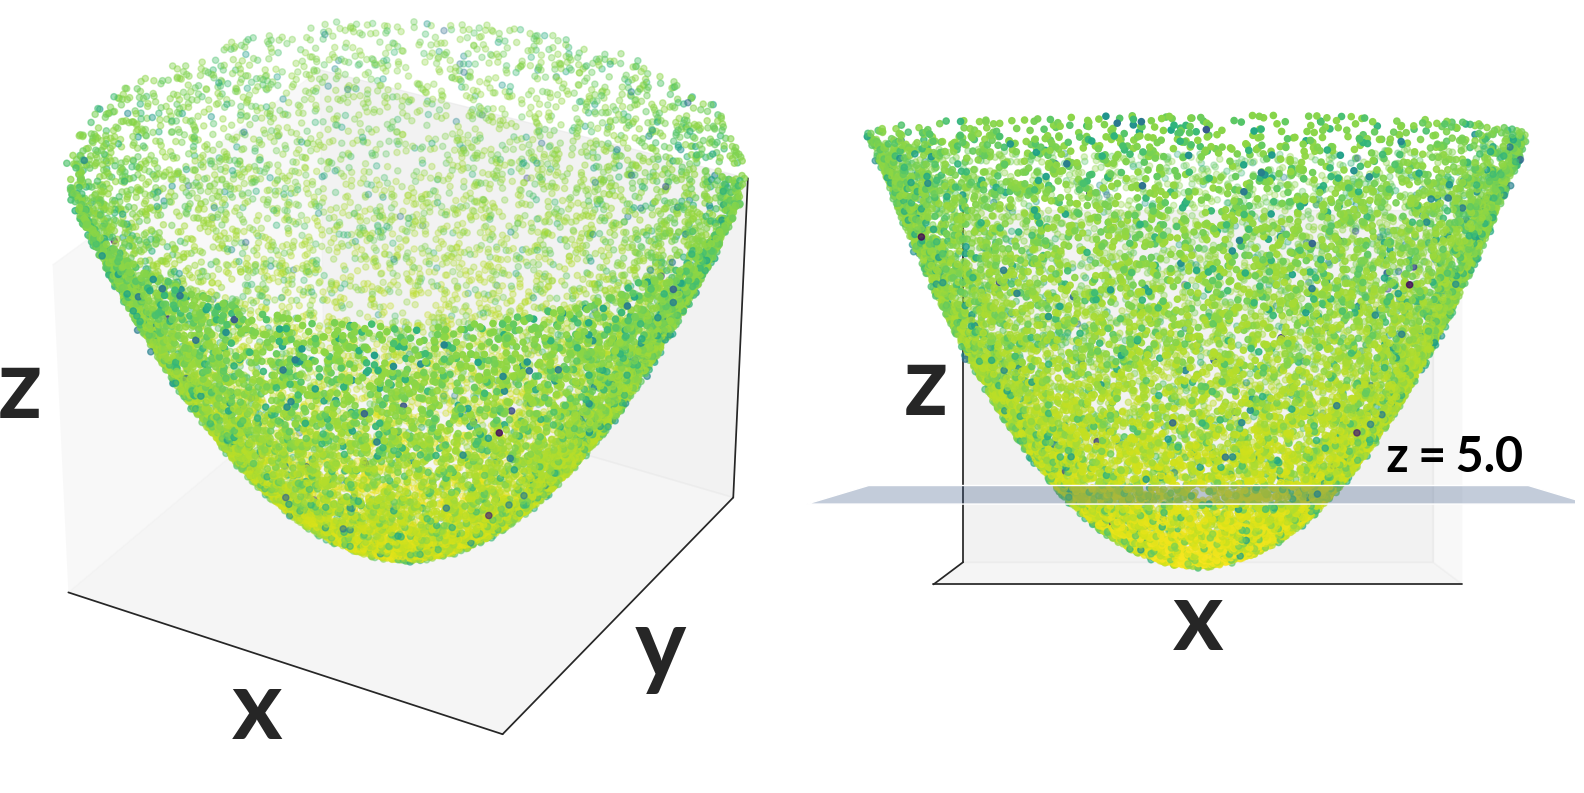

In [47]:
x, y, z = chm["x"], chm["y"], chm["z"]
scores = tr.get_score()
ch = z < 30.0
x = x[ch]
y = y[ch]
z = z[ch]
scores = scores[ch]

# Create a new figure
fig = plt.figure(figsize=(16, 16))  # Adjust the size for better visualization
gs = GridSpec(1, 2)

# Define the x and y range
xp = np.linspace(-4, 4, 2)
yp = np.linspace(-4, 4, 2)
xp, yp = np.meshgrid(xp, yp)
zp = np.full_like(xp, 5)

# First subplot - Original 3D plot
ax1 = fig.add_subplot(gs[0, 0], projection="3d")  # This spans both columns
# ax1.plot_surface(xp, yp, zp, alpha=0.3, zorder=1)
ax1.scatter(x, y, z, c=scores, cmap="viridis")
# ax1.text(2.0, -3.4, 5, "z = 5.0", color="black", zorder=3, fontsize=label_fontsize / 1.7)
ax1.set_zlim(0, 25)
ax1.set_ylim(-4, 4)
ax1.set_xlim(-4, 4)
ax1.set_xlabel("x", fontsize=label_fontsize)
ax1.set_ylabel("y", fontsize=label_fontsize)
ax1.text(
    x=-8.5,
    y=0,
    z=2,
    s="z",
    rotation=90,
    verticalalignment="center",
    fontsize=label_fontsize,
)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

# Define the x and y range
xp = np.linspace(-6, 6, 2)
yp = np.linspace(-6, 6, 2)
xp, yp = np.meshgrid(xp, yp)
zp = np.full_like(xp, 5)

# Second subplot - Rotated 3D plot looking at the XZ plane
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
ax2.set_zlim(0, 25)
ax2.set_ylim(-4, 4)
ax2.set_xlim(-4, 4)
ax2.scatter(x, y, z, c=scores, cmap="viridis")
ax2.plot_surface(xp, yp, zp, alpha=0.3, zorder=1)
ax2.text(
    3.0, -3.4, 6.8, "z = 5.0", color="black", zorder=3, fontsize=label_fontsize / 2
)
ax2.set_xlabel("x", fontsize=label_fontsize)
ax2.set_zlabel("z", fontsize=label_fontsize)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.view_init(elev=0, azim=-90)


# Show the plots
# plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

# Save the figure as an pdf file (optional)
plt.tight_layout()
fig.savefig("img/model_prior.pdf", format="pdf")

plt.show()

## Naive variational guide

In [19]:
# Now, we define our variational proposal.
@genjax.gen
def variational_family(data, ϕ):
    μ1, μ2, log_σ1, log_σ2 = ϕ
    x = grasp.normal_reparam(μ1, jnp.exp(log_σ1)) @ "x"
    y = grasp.normal_reparam(μ2, jnp.exp(log_σ2)) @ "y"

In [20]:
data = genjax.choice_map({"z": 5.0})
objective = grasp.elbo(model, variational_family, data)

In [8]:
# Training.
key = jax.random.PRNGKey(314159)
ϕ = (0.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(objective.value_and_grad_estimate, in_axes=(0, None)))
losses = []
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    losses.append(jnp.mean(loss))
    if i % 1000 == 0:
        print(jnp.mean(loss))
print(ϕ)

-825.4226
-7.987867
-8.034029
-8.206104
-7.992387
-7.880024
-7.936195
-8.985643
-8.162853
-7.8599386
-8.0959015
-8.141094
-8.150928
-8.17004
-8.10012
-8.124427
-8.051115
-8.067102
-8.014355
-7.9789457
(Array(0.00035516, dtype=float32), Array(-2.2183301, dtype=float32), Array(-1.2732011, dtype=float32), Array(-3.3843782, dtype=float32))


### Mean loss after convergence

In [9]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
jnp.mean(loss)

Array(-8.09012, dtype=float32)

### Sampling from the trained variational family

In [10]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

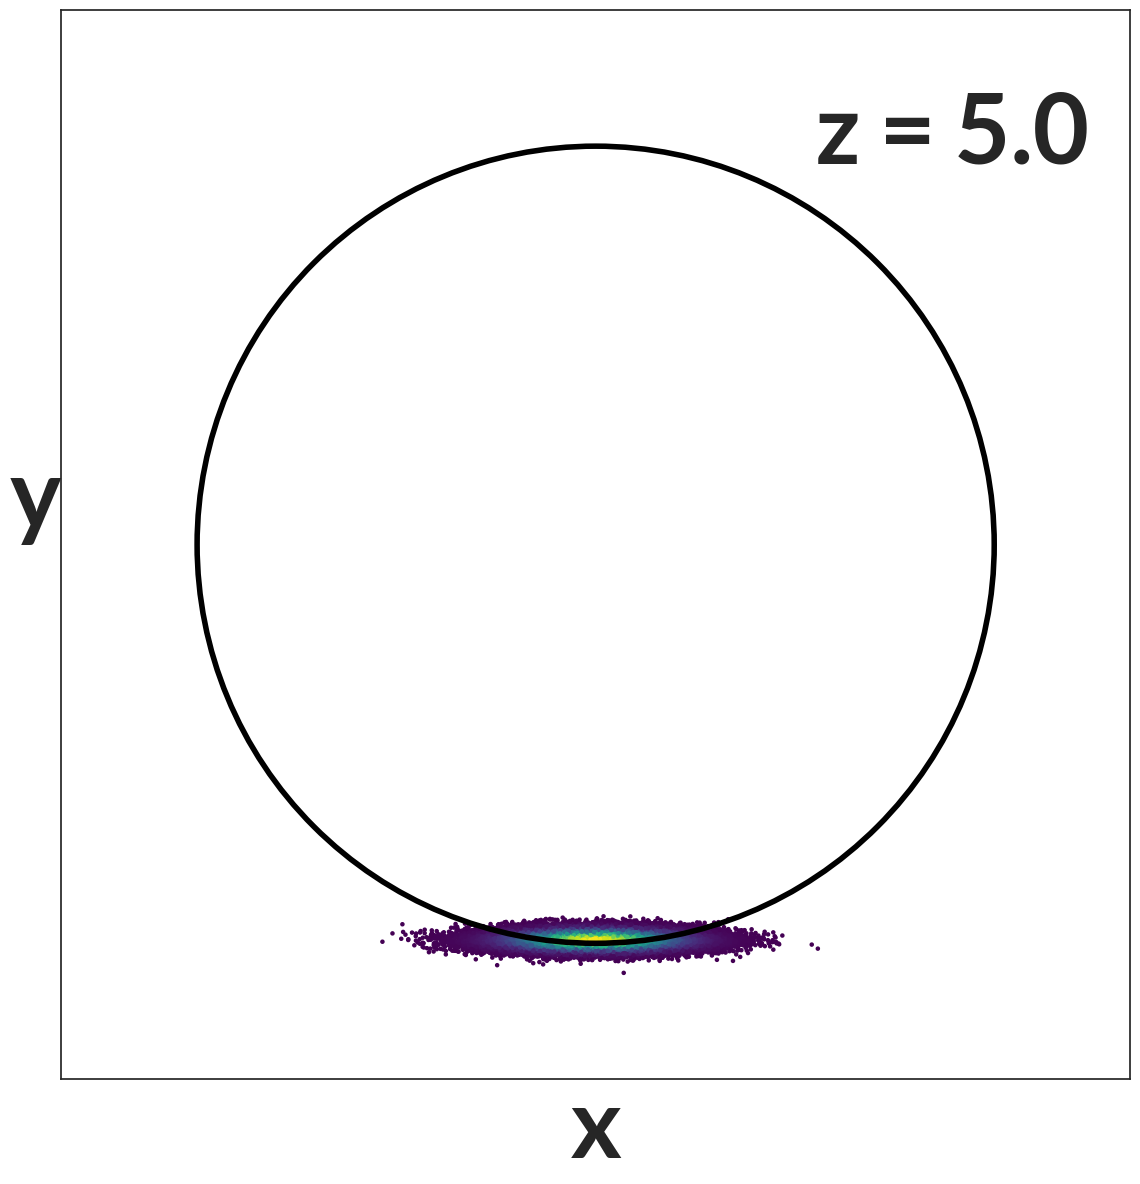

In [11]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(2.0, 2.3, "z = 5.0", ha="center", va="center", fontsize=label_fontsize)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_elbo_samples.pdf", format="pdf")

# Show the plot
plt.show()

In [12]:
# Training.
key = jax.random.PRNGKey(2)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(objective.value_and_grad_estimate, in_axes=(0, None)))
losses = []
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
    losses.append(jnp.mean(loss))
print(ϕ)

-1265.4696
-8.004254
-8.012936


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 │   key, sub_key = jax.random.split(key)                                                    │
│    8 │   sub_keys = jax.random.split(sub_key, 64)                                                │
│    9 │   loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))                             │
│ ❱ 10 │   ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)                       │
│   11 │   if i % 1000 == 0:                                                                       │
│   12 │   │   print(jnp.mean(loss))                                                               │
│   13 │   losses.append(jnp.mean(loss))                                                           │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/tree_util.py:244 in     │
│ tree_map                                                                                         │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/tree_util.py:244 in     │
│ <genexpr>                                                                                        │
│                                                                                                  │
│ in <lambda>:10                                                                                   │
│                                                                                                  │
│    7 │   key, sub_key = jax.random.split(key)                                                    │
│    8 │   sub_keys = jax.random.split(sub_key, 64)                                                │
│    9 │   loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))                             │
│ ❱ 10 │   ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)                       │
│   11 │   if i % 1000 == 0:                                                                       │
│   12 │   │   print(jnp.mean(loss))                                                               │
│   13 │   losses.append(jnp.mean(loss))                                                           │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:317 │
│ in mean                                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

### Mean loss after convergence

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
jnp.mean(loss)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(2.0, 2.3, "z = 5.0", ha="center", va="center", fontsize=label_fontsize)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_elbo_samples_2.pdf", format="pdf")

# Show the plot
plt.show()

## Training with IWAE

$$\text{IWAE ELBO} = E_{\{z_k\}_{k = 0}^N \sim Q}[\log \frac{1}{N}\sum_i w_i(z_i)]$$

where $w_i(z_i) = \frac{P(z_i, x)}{Q(z_i)}$

## 5 particle IWAE

In [ ]:
data = genjax.choice_map({"z": 5.0})
iwae_objective = grasp.iwae_elbo(model, variational_family, data, 5)

In [ ]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
losses = []
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 1)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
    losses.append(jnp.mean(loss))

print(ϕ)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
jnp.mean(loss)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(-2.0, 2.3, "z = 5.0", ha="center", va="center", fontsize=label_fontsize)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_iwae_elbo_5_samples.pdf", format="pdf")


# Show the plot
plt.show()

## 20 particle IWAE

In [ ]:
iwae_objective = grasp.iwae_elbo(
    model, variational_family, genjax.choice_map({"z": 5.0}), 20
)

In [ ]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
losses = []
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
    losses.append(jnp.mean(loss))
print(ϕ)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
jnp.mean(loss)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(-2.0, 2.3, "z = 5.0", ha="center", va="center", fontsize=label_fontsize)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_iwae_elbo_20_samples.pdf", format="pdf")

# Show the plot
plt.show()

## 50 particle IWAE

In [ ]:
iwae_objective = grasp.iwae_elbo(
    model, variational_family, genjax.choice_map({"z": 5.0}), 50
)

In [ ]:
# Training with IWAE.
key = jax.random.PRNGKey(314159)
ϕ = (3.0, 0.0, 1.0, 1.0)
jitted = jax.jit(jax.vmap(iwae_objective.value_and_grad_estimate, in_axes=(0, None)))
losses = []
for i in range(0, 20000):
    key, sub_key = jax.random.split(key)
    sub_keys = jax.random.split(sub_key, 64)
    loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
    ϕ = jtu.tree_map(lambda v, g: v + 1e-3 * jnp.mean(g), ϕ, ϕ_grads)
    if i % 1000 == 0:
        print(jnp.mean(loss))
    losses.append(jnp.mean(loss))
print(ϕ)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 5000)
loss, (_, (_, ϕ_grads)) = jitted(sub_keys, ((), (data, ϕ)))
jnp.mean(loss)

In [ ]:
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
tr = jax.jit(jax.vmap(variational_family.simulate, in_axes=(0, None)))(
    sub_keys, (data, ϕ)
)
chm = tr.strip()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, c=scores, cmap="viridis", marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(-2.0, 2.3, "z = 5.0", ha="center", va="center", fontsize=label_fontsize)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_iwae_elbo_50_samples.pdf", format="pdf")

# Show the plot
plt.show()

In [ ]:
from genjax import gensp


@genjax.gen
def hacky_model(ϕ):
    x = grasp.normal_reparam(0.0, 10.0) @ "x"
    y = grasp.normal_reparam(0.0, 10.0) @ "y"
    rs = x**2 + y**2
    z = grasp.normal_reparam(rs, 0.1 + (rs / 100.0)) @ "z"


@genjax.gen
def hacky_variational_family(tgt):
    (ϕ,) = tgt.args
    μ1, μ2, log_σ1, log_σ2 = ϕ
    x = grasp.normal_reparam(μ1, jnp.exp(log_σ1)) @ "x"
    y = grasp.normal_reparam(μ2, jnp.exp(log_σ2)) @ "y"


key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(sub_key, 50000)
data = genjax.choice_map({"z": 5.0})
chm_variational = gensp.choice_map_distribution(hacky_variational_family)
sir = gensp.CustomImportance(50, chm_variational)
scores, v_chm = jax.vmap(sir.random_weighted, in_axes=(0, None))(
    sub_keys, gensp.target(hacky_model, (ϕ,), data)
)
chm = v_chm.get_leaf_value()

In [ ]:
x, y = chm["x"], chm["y"]
scores = jnp.exp(tr.get_score())

fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(x, y, marker=".", s=20)

# Define the circle
circle = patches.Circle((0.0, 0.0), radius=jnp.sqrt(5.0), fc="none", ec="black", lw=4)

# Add the circle to the plot
ax.add_patch(circle)

ax.text(-2.0, 2.3, "z = 5.0", ha="center", va="center", fontsize=label_fontsize)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x", fontsize=label_fontsize)
ax.set_ylabel("y", fontsize=label_fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

fig.savefig("img/naive_variational_iwae_elbo_50_sir_samples.pdf", format="pdf")

# Show the plot
plt.show()